In [25]:
import emoji
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords 

import csv
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1)
%matplotlib inline

### Utility Functions

In [2]:
def read_csv(filename = "Data/emojify_data.csv"):
    phrase = []
    emoji = []
    
    with open(filename) as csvDataFile:
        csvReader = csv.reader(csvDataFile)
    
        for row in csvReader:
            phrase.append(row[0])
            emoji.append(row[1])
    
    X = np.asarray(phrase)
    Y = np.asarray(emoji, dtype = int)
    
    return X, Y

In [3]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

In [4]:
emoji_dictionary = {"0": "\u2764\uFE0F",    # :heart: prints a black instead of red heart depending on the font
                    "1": ":baseball:",
                    "2": ":smile:",
                    "3": ":disappointed:",
                    "4": ":fork_and_knife:"}

def label_to_emoji(label):
    return emoji.emojize(emoji_dictionary[str(label)], use_aliases = True)

In [5]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r', encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

### Reading the Dataset

In [6]:
X_train, Y_train = read_csv("Data/train_emoji.csv") 
X_test, Y_test = read_csv("Data/tesss.csv") 

In [7]:
maxLen = len(max(X_train, key = len).split())

In [8]:
index = 1
print(X_train[index], label_to_emoji(Y_train[index]))

I am proud of your achievements 😄


In [9]:
# Converting into one hot encoding
Y_oh_train = convert_to_one_hot(Y_train, C = 5)
Y_oh_test = convert_to_one_hot(Y_test, C = 5)

In [10]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs("Data/glove.6B.50d.txt")

In [11]:
def sentences_to_indices(X, word_to_index, max_len):
    
    m = X.shape[0]
    
    X_indices = np.zeros((m, max_len))
    
    for i in range(m):
        sentence_to_words = [w.lower() for w in X[i].split()]
        
        j = 0 
        
        for w in sentence_to_words:
            X_indices[i, j] = word_to_index[w]
            j = j + 1
    return X_indices

In [12]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    
    vocab_len = len(word_to_index) + 1
    emb_dim = word_to_vec_map["cucumber"].shape[0]
    
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]
        
    embedding_layer = Embedding(vocab_len, emb_dim, trainable = False)
    
    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [13]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][1][3] =", embedding_layer.get_weights()[0][1][3])

weights[0][1][3] = -0.3403


In [14]:
def Emojify(input_shape, word_to_vec_map, word_to_index):
    
    sentence_indices = Input(input_shape, dtype = 'int32')
    
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    embeddings = embedding_layer(sentence_indices)
    
    X = LSTM(128, return_sequences = True)(embeddings)
    X = Dropout(0.6)(X)
    X = LSTM(128, return_sequences = False)(X)
    X = Dropout(0.6)(X)
    X = Dense(5)(X)
    X = Activation('softmax')(X)
    
    model = Model(inputs = sentence_indices, outputs = X)
    
    return model

In [15]:
model = Emojify((maxLen,), word_to_vec_map, word_to_index)
model.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 10, 50)            20000050  
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 128)           91648     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
den

In [16]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [17]:
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
Y_train_oh = convert_to_one_hot(Y_train, C = 5)

In [28]:
epochs_val = 150

In [29]:
history = model.fit(X_train_indices, Y_train_oh, epochs = epochs_val, batch_size = 32, shuffle = True)

Epoch 1/150
132/132 [==============================] - 0s - loss: 0.0754 - acc: 0.9773     
Epoch 2/150
132/132 [==============================] - 0s - loss: 0.0729 - acc: 0.9848     
Epoch 3/150
132/132 [==============================] - 0s - loss: 0.2532 - acc: 0.9091     
Epoch 4/150
132/132 [==============================] - 0s - loss: 0.1626 - acc: 0.9545     
Epoch 5/150
132/132 [==============================] - 0s - loss: 0.2981 - acc: 0.9015     
Epoch 6/150
132/132 [==============================] - 0s - loss: 0.0856 - acc: 0.9773     
Epoch 7/150
132/132 [==============================] - 0s - loss: 0.1612 - acc: 0.9545     
Epoch 8/150
132/132 [==============================] - 0s - loss: 0.0813 - acc: 0.9848     
Epoch 9/150
132/132 [==============================] - 0s - loss: 0.0814 - acc: 0.9848     
Epoch 10/150
132/132 [==============================] - 0s - loss: 0.0598 - acc: 0.9924     
Epoch 11/150
132/132 [==============================] - 0s - loss: 0.0489 - acc

In [20]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxLen)
Y_test_oh = convert_to_one_hot(Y_test, C = 5)
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print("Test accuracy = ", acc)

32/56 [================>.............] - ETA: 0sTest accuracy =  0.9285714285714286


In [32]:
x_test = np.array(['this is not working'])
X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
print(x_test[0] + ' ' + label_to_emoji(np.argmax(model.predict(X_test_indices))))

this is not working 😞


### Loss Validation 

In [86]:
print(history.history.keys())

dict_keys(['loss', 'acc'])


In [87]:
loss_val = history.history['loss']

### Ploting the Loss values

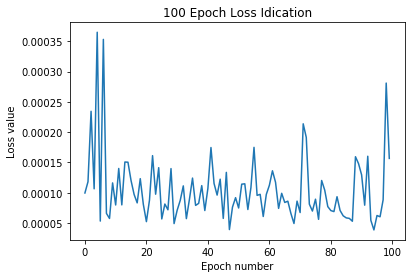

In [88]:
plt.plot(loss_val)
plt.xlabel("Epoch number")
plt.ylabel("Loss value")
plt.title(str(epochs_val) + " Epoch Loss Idication")
plt.show()